In [1]:
%pylab inline
import sklearn.feature_extraction.image
import sklearn.metrics
import os
import pyprind
#climate.enable_default_logging()
import glob
from scipy.ndimage.filters import median_filter
import datetime
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython import display

In [3]:
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

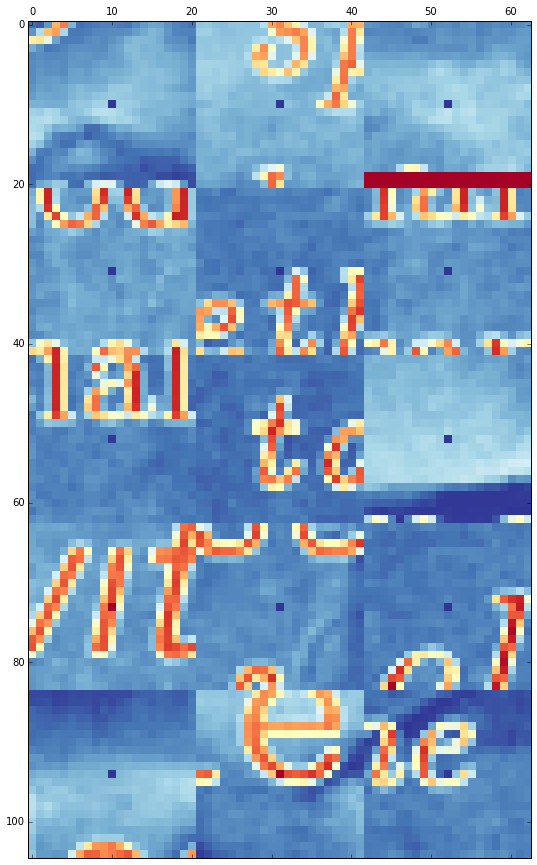

In [4]:
patch_size = 21
patch_center = patch_size / 2
max_patches = 500
n_images = 10

all_images = [int(filter(char.isdigit, image)) for image in glob.glob("train/*.png")]
#all_train_images = [i for i in all_images if i % 6]
#all_valid_images = [i for i in all_images if not i % 6]
all_train_images = all_images
all_valid_images = all_images

def enlargen_image(image):
    enlargened_size = (image.shape[0] + patch_center*2, image.shape[1] + patch_center*2)
    enlargened_image = np.zeros(enlargened_size, dtype=np.float32)
    enlargened_image[patch_center:-patch_center, patch_center:-patch_center] = image
    return enlargened_image

def batch(mode):
    if mode == 'train':
        images = np.random.choice(all_train_images, n_images)
    else:
        images = np.random.choice(all_valid_images, n_images)
        
    X_patches = np.zeros((0, patch_size, patch_size))
    y_patches = np.zeros((0, patch_size, patch_size))
    
    for image in images:
        X_image = imread('train/%d.png' % image)
        y_image = imread('train_cleaned/%d.png' % image)
        
        enlargened_X = enlargen_image(X_image)
        enlargened_y = enlargen_image(y_image)
        rand_seed = np.random.randint(0, 1000000)

        X_p = sklearn.feature_extraction.image.extract_patches_2d(
            enlargened_X, 
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=rand_seed)
        X_patches = np.concatenate([X_patches, X_p])
        y_p = sklearn.feature_extraction.image.extract_patches_2d(
            enlargened_y,
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=rand_seed)
        y_patches = np.concatenate([y_patches, y_p])
        
    y_cls = y_patches[:, patch_center, patch_center]
    X_patches = X_patches[:, newaxis, :, :]
    return X_patches, y_cls
def train_batch():
    return batch('train')
def valid_batch():
    return batch('valid')
def view_batch():
    xs, ys = train_batch()
    choices = np.random.choice(xs.shape[0], 3)
    ximgs = xs[choices, 0]
    ximgs[:, patch_size/2, patch_size/2] = ys.flatten()[choices]
    return np.concatenate(ximgs, axis=1)
#xs, ys = train_batch()
matshow(np.concatenate([view_batch() for _ in range(5)]), cmap='RdYlBu')

In [5]:
import keras.models
import keras.layers.core as kcore
import skimage.filters
import keras.layers.convolutional as kconv

Using gpu device 0: GeForce GTX 770


In [ ]:
model = keras.models.Sequential()
model.add(kconv.Convolution2D(64, 1, 7, 7, activation='relu'))
model.add(kconv.MaxPooling2D((2,2)))
model.compile(loss='mse', optimizer='rmsprop')
xs, ys = train_batch()
pred = model.predict(xs)
print pred.shape
#matshow(pred[1, 2], cmap='gray')

In [7]:
import theano.tensor as T
import theano

def truncating_func(output):
    #return output
    upper_trunc = T.switch(T.ge(output, 1), 1 + (output - 1) * 0.05, output)
    lower_trunc = T.switch(T.ge(0, upper_trunc), upper_trunc * 0.05, upper_trunc)
    return lower_trunc

def clipping_mse(y_true, y_pred):
    y_trunc = truncating_func(y_pred)
    diff = (y_true - y_trunc)**2
    return diff.mean()

y_true = T.as_tensor(np.random.normal(size=500))
y_pred = T.as_tensor(np.random.normal(size=500))
fn = theano.function([], clipping_mse(y_true, y_pred), allow_input_downcast=True)
fn(), sklearn.metrics.mean_squared_error(y_true.value, y_pred.value)

(array(1.1279527099230098), 1.8987633780813149)

In [39]:
# Convolutional network
model = keras.models.Graph()
model.add_input('input', ndim=4)
model.add_node(kconv.Convolution2D(64, 1, 7, 7, activation='sigmoid'), name='conv1', input='input')
model.add_node(kconv.MaxPooling2D((2,2)), name='max1', input='conv1')
model.add_node(kcore.Flatten(), name='flatconv', input='max1')
model.add_node(kcore.Dense(64*(7**2), 32, activation='sigmoid'), name='input_dense', input='flatconv')

model.add_node(kcore.Flatten(), name='flatin', input='input')
model.add_node(kcore.Dense(32 + patch_size**2, 127, activation='relu'), 
               name='dense1', inputs=['flatin', 'input_dense'])
model.add_node(kcore.Dropout(0.25), name='dropout1', input='dense1')
model.add_node(kcore.Dense(127, 127, activation='sigmoid'), name='dense2', input='dropout1')
model.add_node(kcore.Dropout(0.25), name='dropout2', input='dense2')
model.add_node(kcore.Dense(127, 1, activation='linear'), name='dense3', input='dropout2')
model.add_output('output', input='dense3')
model.compile('adam', {'output': clipping_mse})
#model.load_weights('keras_intraining.hf5')

xs, ys = train_batch()
xs = xs.reshape((xs.shape[0], patch_size, patch_size))[:, newaxis, :, :]
model.predict({'input': xs})['output'].flatten()

array([-0.26333767, -0.29519868, -0.18973488, ..., -0.18217626,
       -0.24201944, -0.2154022 ])

In [48]:
# Just a network
model = keras.models.Graph()
model.add_input('input', ndim=4)
model.add_node(kcore.Flatten(), name='flatin', input='input')

#####################
model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='relu'), 
               name='dense1', 
               input='flatin')
model.add_node(kcore.Dropout(0.25), input='dense1', name='dropout1')
for i in range(2, 4):
    model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='relu'), 
                   name='dense%d' % i, 
                   input='dropout%d' % (i-1))
    model.add_node(kcore.Dropout(0.25), input='dense%d' % i, name='dropout%d' % i)
    print('dense%d' % i)
i += 1
model.add_node(kcore.Dense(2*patch_size**2, patch_size**2, activation='relu'), 
                   name='dense%d' % i, 
                   inputs=['flatin', 'dropout%d' % (i-1)])
model.add_node(kcore.Dropout(0.25), input='dense%d' % i, name='dropout%d' % i)
for i in range(5, 7):
    model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='relu'), 
                   name='dense%d' % i, 
                   input='dropout%d' % (i-1))
    model.add_node(kcore.Dropout(0.25), input='dense%d' % i, name='dropout%d' % i)
    print('dense%d' % i)
i += 1
#########################

model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='sigmoid'), 
               name='sig_dense1', 
               input='flatin')
model.add_node(kcore.Dropout(0.25), input='sig_dense1', name='sig_dropout1')
for j in range(2, 4):
    model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='sigmoid'), 
                   name='sig_dense%d' % j, 
                   input='sig_dropout%d' % (j-1))
    model.add_node(kcore.Dropout(0.25), input='sig_dense%d' % j, name='sig_dropout%d' % j)
    print('sig_dense%d' % j)
j += 1
model.add_node(kcore.Dense(2*patch_size**2, patch_size**2, activation='sigmoid'), 
                   name='sig_dense%d' % j,
                   inputs=['flatin', 'sig_dropout%d' % (j-1)])
model.add_node(kcore.Dropout(0.25), input='sig_dense%d' % j, name='sig_dropout%d' % j)
for j in range(5, 7):
    model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='sigmoid'), 
                   name='sig_dense%d' % j, 
                   input='sig_dropout%d' % (j-1))
    model.add_node(kcore.Dropout(0.25), input='sig_dense%d' % j, name='sig_dropout%d' % j)
    print('sig_dense%d' % j)
j += 1

############

model.add_node(kcore.Dense(2*patch_size**2, 1, activation='linear'), 
               name='outmerge', 
               inputs=['dense%d' % (i-1), 'sig_dense%d' % (j-1)])

model.add_output('output', input='outmerge')
model.compile('adam', {'output': clipping_mse})
#model.load_weights('keras_intraining.hf5')

xs, ys = train_batch()
xs = xs.reshape((xs.shape[0], patch_size, patch_size))[:, newaxis, :, :]
model.predict({'input': xs})['output'].flatten()

dense2
dense3
dense5
dense6
sig_dense2
sig_dense3
sig_dense5
sig_dense6


array([-0.41687927, -0.44060498, -0.40695858, ..., -0.45006502,
       -0.45942882, -0.42003396])

In [34]:
# Classified input network
model = keras.models.Graph()
model.add_input('input', ndim=4)
model.add_node(kcore.Flatten(), 
               name='flatin', 
               input='input')

#### The classification part
model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='sigmoid'),
               name='cls1', 
               input='flatin')
model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='sigmoid'), 
               name='cls2', 
               input='cls1')
model.add_node(kcore.Dense(patch_size**2, 64, activation='sigmoid'), 
               name='cls3', 
               input='cls2')

#### The linear(ish) preprocessor
model.add_node(kcore.Dense(patch_size**2, patch_size**2, activation='relu'), 
               name='preprocess1', 
               input='flatin')

#### The combiner
model.add_node(kcore.Dense(64+patch_size**2, 256, activation='relu'), 
               name='combine1',
               inputs=['preprocess1', 'cls3'])
model.add_node(kcore.Dense(256, 256, activation='relu'),
               name='combine2', 
               input='combine1')
model.add_node(kcore.Dense(256, 256, activation='relu'),
               name='combine3', 
               input='combine2')
model.add_node(kcore.Dense(256, 1, activation='linear'), 
               name='combine4', 
               input='combine3')

model.add_output('output', input='combine4')
model.compile('adam', {'output': clipping_mse})
#model.load_weights('keras_intraining.hf5')

xs, ys = train_batch()
xs = xs.reshape((xs.shape[0], patch_size, patch_size))[:, newaxis, :, :]
model.predict({'input': xs})['output'].flatten()

array([-0.09148646, -0.1436056 , -0.26030254, ..., -0.21831332,
       -0.29153088, -0.03582814])

In [49]:
def apply_model(image, exp):
    patches = sklearn.feature_extraction.image.extract_patches_2d(image, (patch_size, patch_size))
    patches = patches[:, newaxis, :, :]
    denoised_values = exp.predict({'input': patches})['output']
    #return denoised_values
    return clip(denoised_values, 0, 1)

In [62]:
trainerrs, errs = [], []
trainerr = model.train_on_batch({'input': xs, 'output': ys[:, newaxis]})
err = model.test_on_batch({'input': xs, 'output': ys[:, newaxis]})
trainerrs.append(trainerr)
errs.append(err)

In [57]:
def runtest(ax):
    imchoice = np.random.choice(all_train_images)
    actual = imread('train/%d.png' % imchoice).astype(np.float32)
    cleaned = imread('train_cleaned/%d.png' % imchoice).astype(np.float32)

    image = enlargen_image(actual)
    denoised = apply_model(image, model)
    pred = denoised.reshape(actual.shape)

    diff = np.abs(cleaned - pred)

    import sklearn.metrics
    err = sklearn.metrics.mean_squared_error(cleaned, pred)**0.5

    im = ax.matshow(
        np.clip(np.concatenate([
            np.concatenate([actual, pred], axis=1),
            np.concatenate([diff, cleaned], axis=1)
        ]), -1, 2), cmap='cubehelix', interpolation='none')
    plt.colorbar(im)
    ax.set_title(str(err))
    #display.clear_output(wait=True)
    #display.display(pyplot.gcf())

In [59]:
import scipy.signal

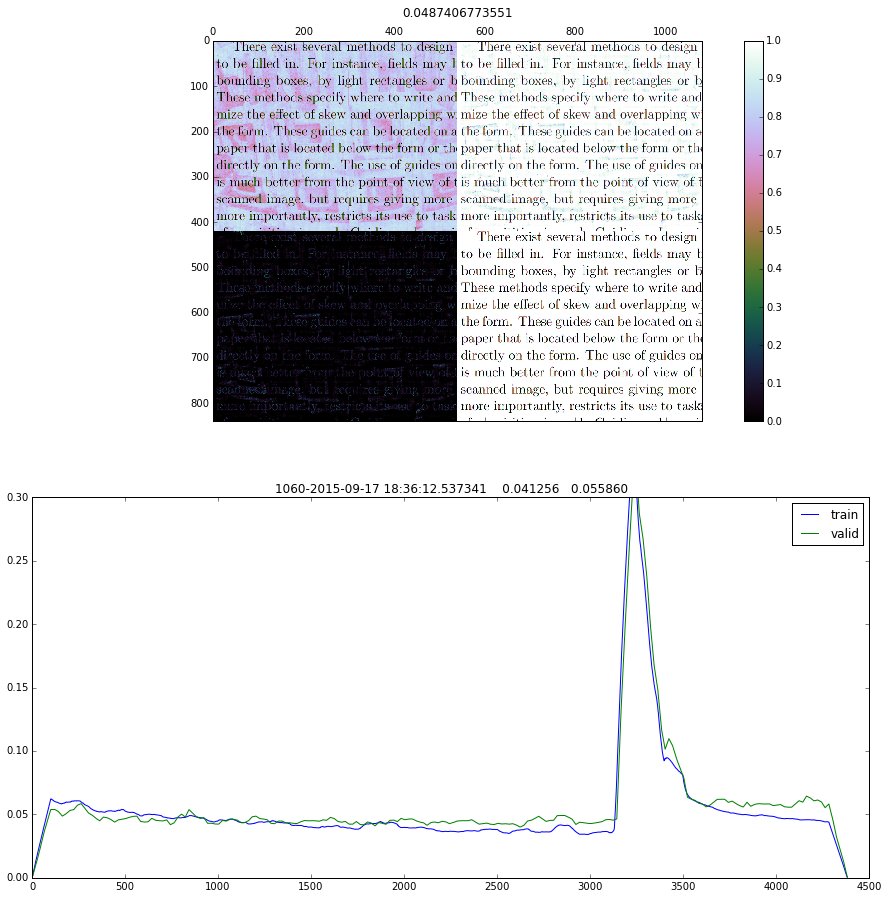

KeyboardInterrupt: 

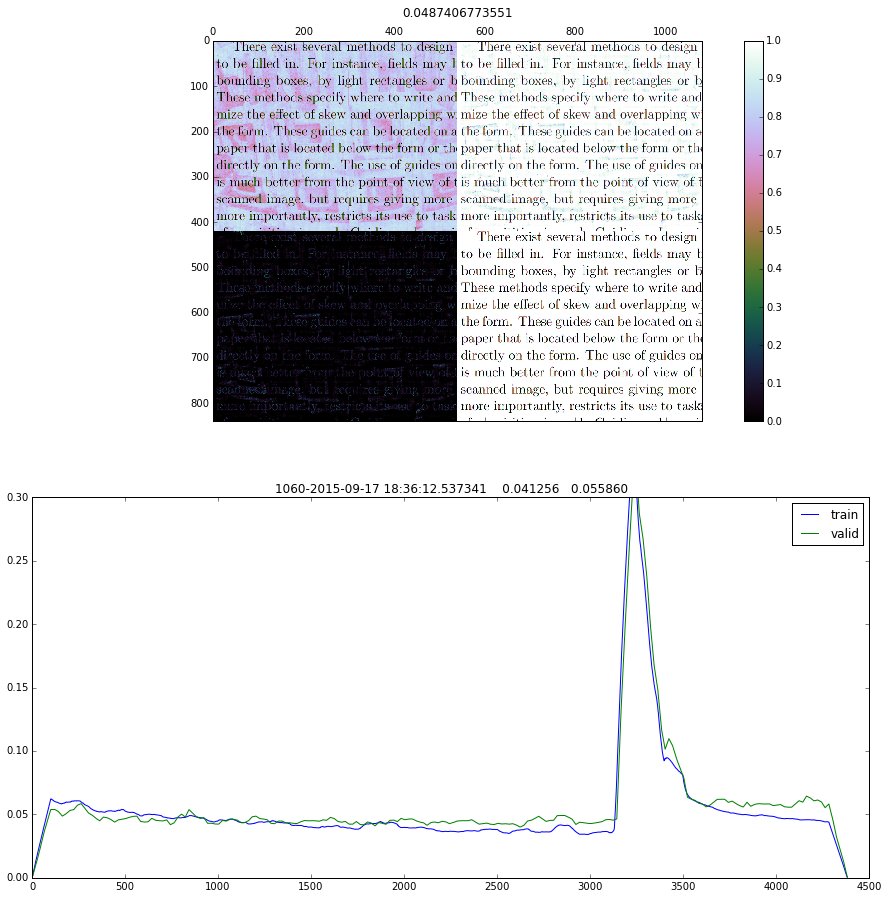

In [65]:
i = 0
while True:
    xs, ys = train_batch()
    xs = xs.reshape((xs.shape[0], patch_size, patch_size))[:, newaxis, :, :]
    trainerr = model.train_on_batch({'input': xs, 'output': ys[:, newaxis]})
    if i % 20 == 0:
        xs, ys = valid_batch()
        xs = xs.reshape((xs.shape[0], patch_size, patch_size))[:, newaxis, :, :]
        err = model.test_on_batch({'input': xs, 'output': ys[:, newaxis]})
        model.save_weights('keras_intraining_bigstack.hf5', overwrite=True)
        pyplot.clf()
        fig = pyplot.figure(1)
        ax1 = pyplot.subplot(211)
        runtest(ax1)
        ax2 = pyplot.subplot(212)
        ax2.plot(scipy.signal.convolve(np.ones(100)/100, trainerrs[:]), label='train')
        ax2.set_ylim(0, 0.3)
        ax2.plot(scipy.signal.convolve(np.ones(100)/100, errs[:]), label='valid')
        ax2.legend()
        ax2.set_title("%d-%s    %04f   %04f" % (i, datetime.datetime.now(), trainerr**0.5, err ** 0.5))
        display.clear_output(wait=True)
        display.display(pyplot.gcf())
    #if i > 500:
    #    break
    i += 1
    trainerrs.append(trainerr**0.5)
    errs.append(err**0.5)

In [26]:
model.save_weights('keras_model.pkl')

[WARNING] keras_model.pkl already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


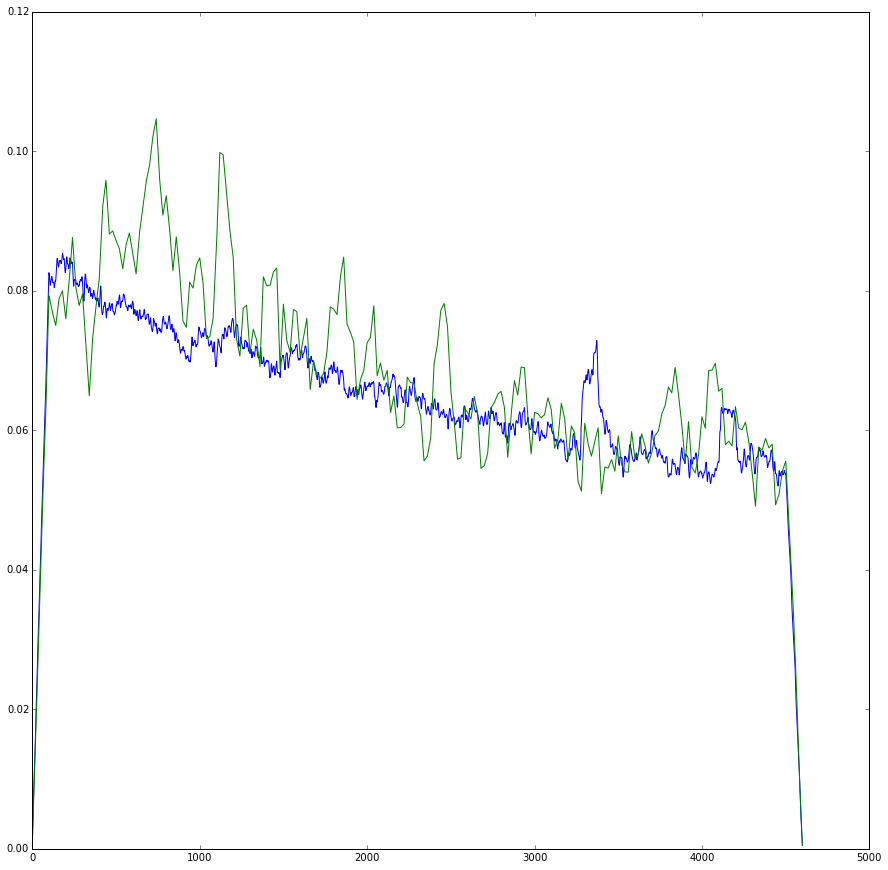

In [53]:
plot(np.convolve(trainerrs[4000:], np.ones(100)/100))
#plot(trainerrs)
plot(np.convolve(errs[4000:], np.ones(100)/100))
#plot(errs)

<matplotlib.colorbar.Colorbar instance at 0x7f12666625a8>

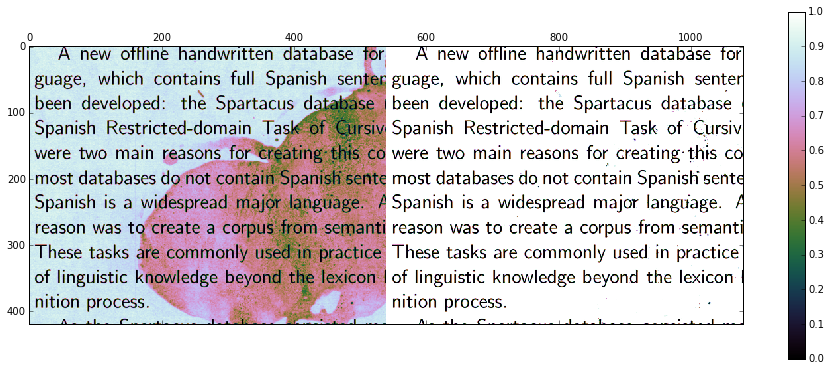

In [27]:
filename = 'test/109.png'

actual = imread(filename).astype(np.float32)
image = enlargen_image(actual)
denoised = apply_model(image, model)
pred = denoised.reshape(actual.shape)

matshow(np.concatenate([actual, pred], axis=1), cmap='cubehelix')
plt.colorbar()

In [28]:
pred2 = np.copy(pred)
from skimage.filters import rank
from skimage.morphology import disk
from skimage import exposure

pred2 = exposure.equalize_adapthist(pred2)
pred2[pred2 > 0.8] = 1
pred2[pred2 < 0.2] = 0
print sklearn.metrics.mean_squared_error(cleaned, pred2)**0.5

matshow(pred2 - cleaned, cmap='cubehelix')
colorbar()
matshow(rank.entropy(pred, disk(3)), cmap='summer')
colorbar()


/home/riri/.virtualenvs/deeplearning/local/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


NameError: name 'cleaned' is not defined

<matplotlib.colorbar.Colorbar instance at 0x7f12eb58eb90>

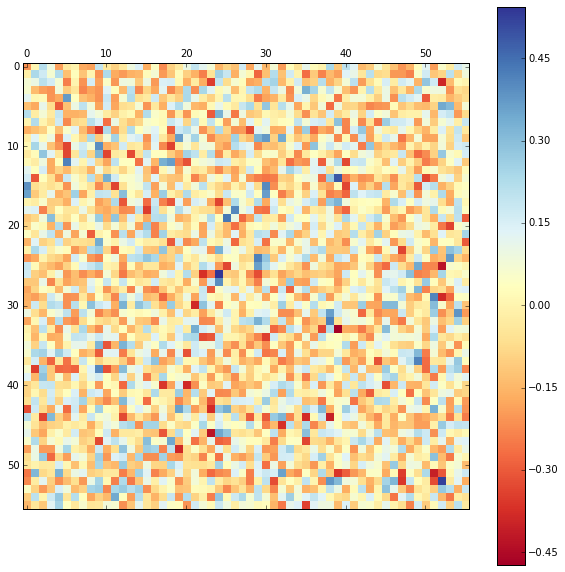

In [159]:
w = model.nodes['conv1'].W.get_value()
ww = w.reshape((64,7,7))
w_mat = np.zeros((8*7, 8*7))
for i in range(8):
    for j in range(8):
        f = ww[i*8+j, :]
        w_mat[i*7:(i+1)*7, j*7:(j+1)*7] = f
matshow(w_mat, cmap='RdYlBu')
pyplot.colorbar()

In [29]:
def calculate_err(image_set, note):
    mses = []
    squared_error = 0
    n = 0

    for imname in pyprind.prog_bar(image_set):
        image = enlargen_image(imread('train/%d.png' % imname))
        cleaned = imread('train_cleaned/%d.png' % imname)
        denoised = apply_model(image, model)
        pred = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))

        squared_error += np.sum((pred - cleaned)**2)
        n += cleaned.size
        mse = sklearn.metrics.mean_squared_error(cleaned, pred)**0.5
        mses.append(mse)
    print "MSE for %s examples is %f" % (note, (squared_error / n)**0.5)
    print "Average of MSE for %s examples is %f" % (note, np.mean(mses))

calculate_err(all_valid_images, "VALIDATION")
#calculate_err(all_train_images, "TRAINING")

0%                          100%
[##############################] | ETA[sec]: 0.000 

MSE for VALIDATION examples is 0.014173
Average of MSE for VALIDATION examples is 0.014071



Total time elapsed: 228.233 sec


# TODO

- submission
- loss function improvements
- parameter search
- deep highways and deeper nets
- more patience
- better edge detection (ie, not just a blacked out zone)

In [30]:
entries = []
for directory, subdirs, files in os.walk('test'):
    for image in pyprind.prog_bar([f for f in files if f.endswith('.png')]):
        image_number = int(''.join([n for n in image if n.isdigit()]))
        X_image = imread(os.path.join(directory, image))
        enlarged_size = (X_image.shape[0] + patch_center*2, X_image.shape[1] + patch_center*2)
        enlargened_X = np.zeros(enlarged_size, dtype='float32')
        enlargened_X[patch_center:-patch_center, patch_center:-patch_center] = X_image
        pred = apply_model(enlargened_X, model).reshape(X_image.shape)
        imsave(os.path.join('denoised', image), pred, cmap='cubehelix')
        for row in range(pred.shape[0]):
            for col in range(pred.shape[1]):
                entries.append(("%d_%d_%d" % (image_number, row+1, col+1), pred[row, col]))

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 136.766 sec


In [31]:
import csv
import gzip
with gzip.open('submission.csv.gz', 'w', 9) as subfile:
    writer = csv.writer(subfile)
    writer.writerow(('id', 'value'))
    writer.writerows(entries)